/var/folders/bx/2rrprkyj5y3gz4vsms51tgf00000gn/T/ipykernel_730/1063826117.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_processed']=df['review'].str.replace("@\S+|https?:\S+|http?:\S|[^a-zA-z0-9]+"," ")
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ameerfaizal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ameerfaizal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ameerfaizal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ameerfaizal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ameerfaizal/nltk_data...
[nltk_data]   Package averaged_perceptron_t

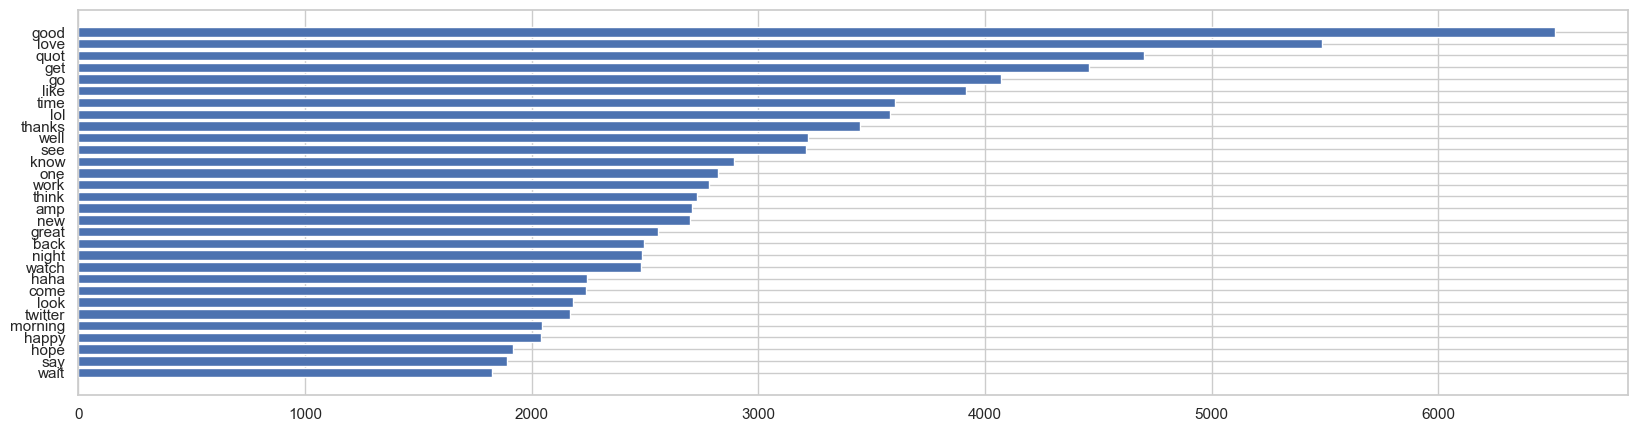

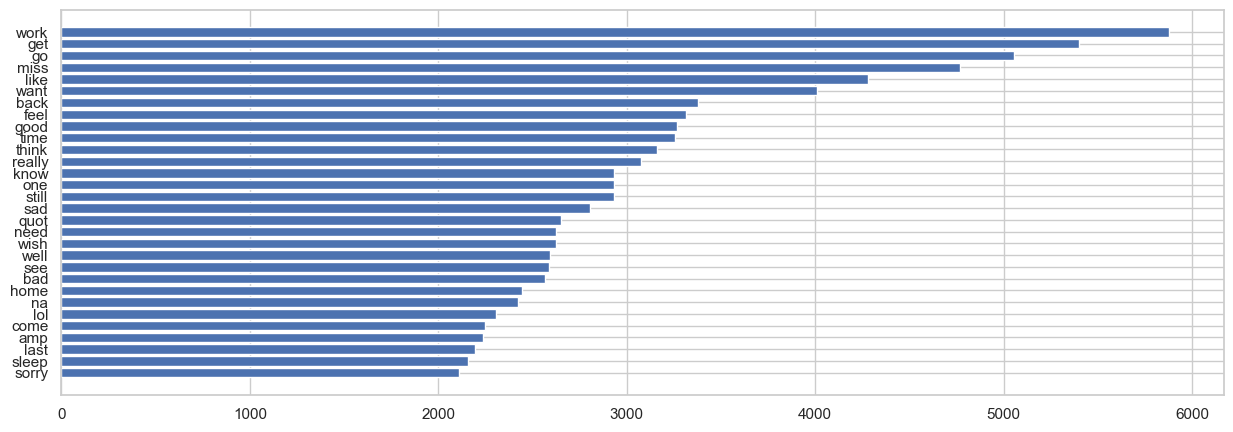

/Users/ameerfaizal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.8269884788531845

In [5]:
#Importing Utilities
import numpy as np
import pandas as pd
Dataset_Encoding="ISO-8859-1"
df=pd.read_csv('/Users/ameerfaizal/Documents/twitter_new.csv',encoding=Dataset_Encoding,header=None)
df.columns =['target', 'ids', 'date', 'flag','user','review']
df.shape
df=df.replace({'target' : { 0 : 'N', 4 : 'P'}})
df=df.drop(['ids','date','flag','user'], axis=1)
df = df.sample(frac =.1)
df['target'].value_counts() 
df['review_processed']=df['review'].str.replace("@\S+|https?:\S+|http?:\S|[^a-zA-z0-9]+"," ")
df['review_processed']=df['review_processed'].apply(lambda row:' '.join([word for word in row.split() if len(word)>2]))
df['review_processed']=[review.lower() for review in df['review_processed']]
#For removing stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
stop_words=stopwords.words('english')
add_words=['get','day','go','today','make']
stop_words.extend(add_words)
#function to remove stopwords
def remove_stopwords(rev):
    rev_tokenized=word_tokenize(rev)
    rev_new=" ".join([i for i in rev_tokenized if i not in stop_words])
    return rev_new
df['review_processed']=[remove_stopwords(r) for r in df['review_processed']]
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer=WordNetLemmatizer()
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
#lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
    nltk_tagged=nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])),nltk_tagged)
    lemmatized_sentence=[]
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatized_sentence)

df['review_processed']=df['review_processed'].apply(lambda x:lemmatize_sentence(x))
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from nltk import FreqDist
all_words_df=df.loc[df['target']=='P',:]
all_words=' '.join([text for text in all_words_df['review_processed']])
all_words=all_words.split()
words_df=FreqDist(all_words)
words_df=pd.DataFrame({'word':list(words_df.keys()),'count':list(words_df.values())})
words_df=words_df.nlargest(columns="count",n=30)
words_df.sort_values('count',inplace=True)
#plotting
plt.figure(figsize=(20,5))
ax=plt.barh(words_df['word'],width=words_df['count'])
plt.show()
sns.set(style='whitegrid')
from nltk import FreqDist
all_words_df=df.loc[df['target']=='N',:]
all_words=' '.join([text for text in all_words_df['review_processed']])
all_words=all_words.split()
words_df=FreqDist(all_words)
words_df=pd.DataFrame({'word':list(words_df.keys()),'count':list(words_df.values())})
words_df=words_df.nlargest(columns="count",n=30)
words_df.sort_values('count',inplace=True)
#plotting
plt.figure(figsize=(15,5))
ax=plt.barh(words_df['word'],width=words_df['count'])
plt.show()
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(max_features=3000)
X=tfidf.fit_transform(df.review_processed).toarray()
y=df.target.map({'P':1,'N':0}).values
featureNames=tfidf.get_feature_names()
X,y
#splitting the dataset into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.20)
X_train.shape,X_test.shape
from sklearn.naive_bayes import MultinomialNB
MNB= MultinomialNB()
MNB.fit(X_train,y_train)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,MNB.predict_proba(X_test)[:,1])